In [ ]:
!pip install pina-mathlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.0/135.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 28.3 MB/s eta 0:00:00


In [ ]:
!pip install matplotlib==3.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires matplotlib>=3.7.1, but you have matplotlib 3.7.0 which is incompatible.
plotnine 0.14.0 requires matplotlib>=3.8.0, but you have matplotlib 3.7.0 which is incompatible.


In [ ]:
# importing the necessary libraries

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.geometry import CartesianDomain
from pina.operators import grad
from pina.equation import Equation
from pina import Condition
from pina.equation.equation_factory import FixedValue
import torch
import numpy as np
from scipy.stats import norm
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
from pina import Plotter
import numpy
from pytorch_lightning.loggers import TensorBoardLogger

**3.1 One-Dimensional Linear Case**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1500` reached.


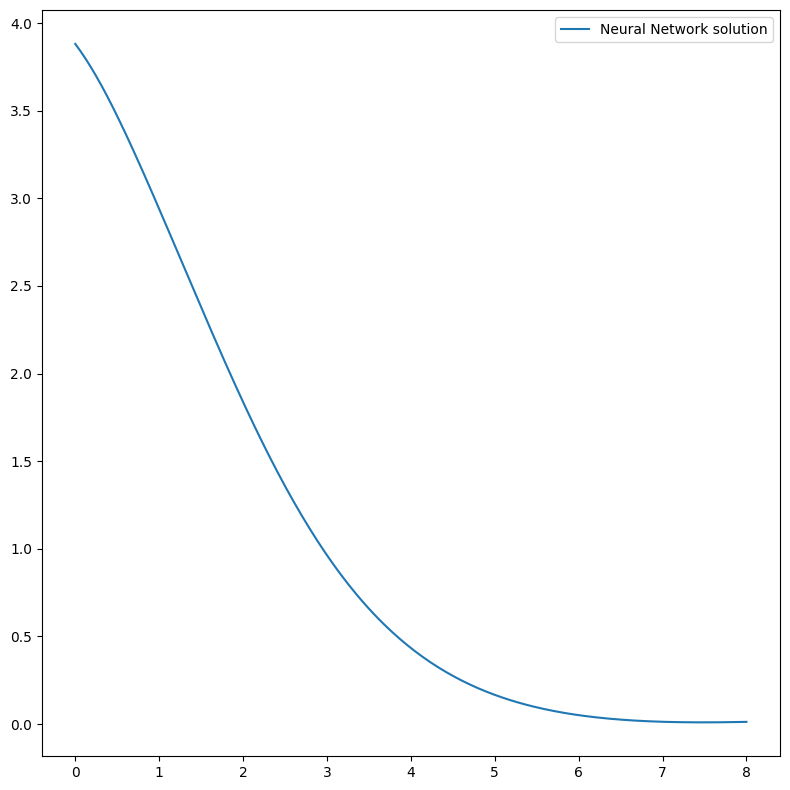

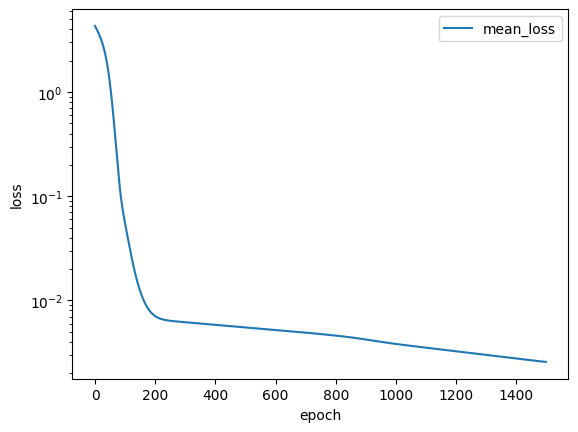

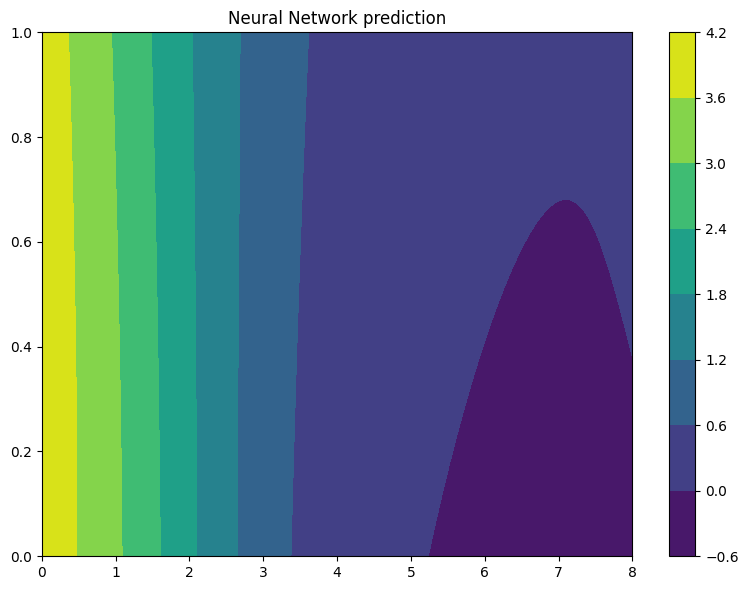

In [ ]:
class BlackScholesPDE_1D(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s': [0, 8]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s = grad(output_, input_, components=['v'], d=['s'])
    v_ss = grad(v_s, input_, components=['dvds'], d=['s'])
    s = input_.extract(['s'])
    v = output_.extract(['v'])
    return v_t  - ((0.3 * 0.3) * (s * s) / 2) * v_ss - 0.03 * s * v_s + 0.03 * v

  def initial_condition(input_, output_):
    return output_.extract(['v']) - torch.max(torch.tensor(4.) - input_.extract(['s']), torch.tensor(0.))

  def boundary_condition(input_, output_):
    return output_.extract(['v']) - 4 * torch.exp(- 0.03 * input_.extract(['t']))



  conditions = {
      'D': Condition(location=CartesianDomain({'s': [0, 8], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s': [0, 8], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s': 0, 't': [0, 1]}), equation=Equation(boundary_condition)),
      'BC2': Condition(location=CartesianDomain({'s': 8, 't': [0, 1]}), equation=FixedValue(0.)),
  }

problem = BlackScholesPDE_1D()
problem.discretise_domain(n=2540, mode="random", variables="all", locations="all")
problem.discretise_domain(n=80, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=160, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)
trainer = Trainer(solver=pinn, max_epochs=1500, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)
trainer.train()

p1 = Plotter()
p1.plot(solver=pinn, fixed_variables={'t' : 1.0})
p1.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p1.plot(solver=pinn)

**3.2 One-dimensional nonlinear case**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3500` reached.


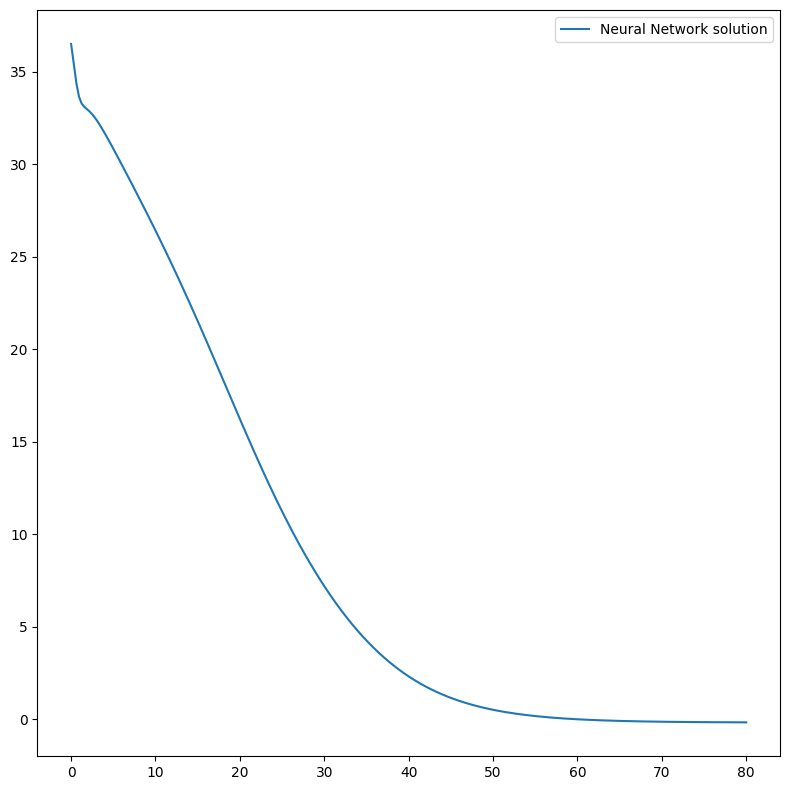

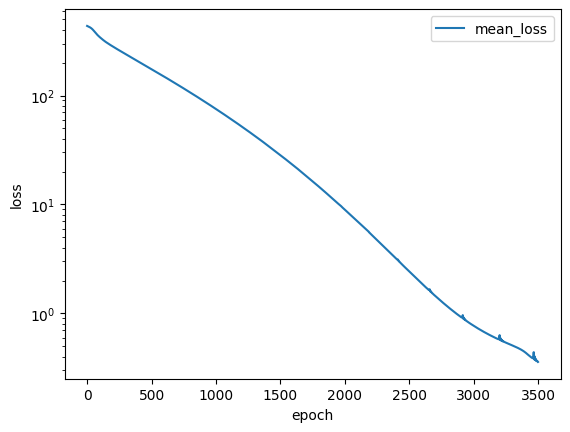

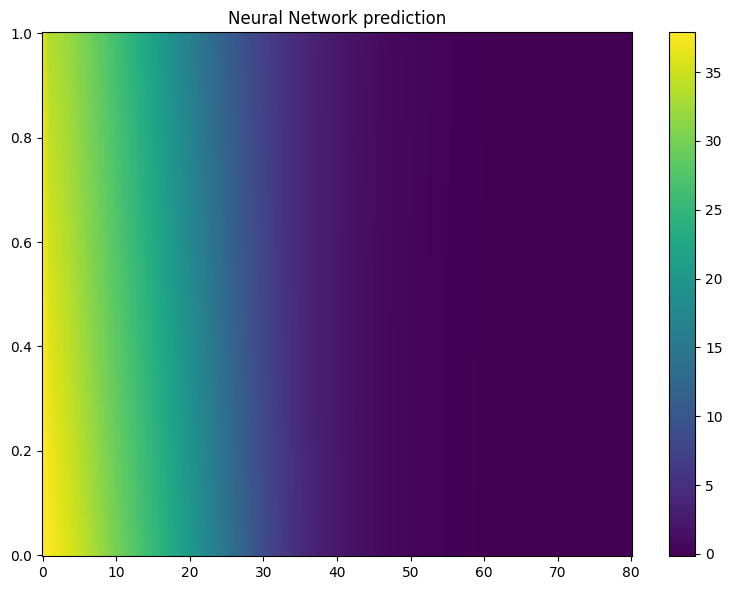

In [ ]:
class BlackScholesPDE_1D_nonlinear(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s': [0, 80]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s = grad(output_, input_, components=['v'], d=['s'])
    v_ss = grad(v_s, input_, components=['dvds'], d=['s'])
    s = input_.extract(['s'])
    v = output_.extract(['v'])
    k_sigma = (0.02/0.2)*np.sqrt(8/(np.pi*(1/12)))
    return v_t  - ((0.2 * 0.2)*(1+ (k_sigma * torch.tensor(np.sign(v_ss.detach().numpy())))) * (s * s) / 2) * v_ss - 0.1 * s * v_s + 0.1 * v

  def initial_condition(input_, output_):
    return output_.extract(['v']) - torch.max(torch.tensor(40.) - input_.extract(['s']), torch.tensor(0.))

  def boundary_condition(input_, output_):
    return output_.extract(['v']) - 40 * torch.exp(- 0.1 * input_.extract(['t']))



  conditions = {
      'D': Condition(location=CartesianDomain({'s': [0, 80], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s': [0, 80], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s': 0, 't': [0, 1]}), equation=Equation(boundary_condition)),
      'BC2': Condition(location=CartesianDomain({'s': 80, 't': [0, 1]}), equation=FixedValue(0.)),
  }

problem = BlackScholesPDE_1D_nonlinear()
problem.discretise_domain(n=2540, mode="random", variables="all", locations="all")
problem.discretise_domain(n=80, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=160, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)
trainer = Trainer(solver=pinn, max_epochs=3500, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)
trainer.train()

p2 = Plotter()
p2.plot(solver=pinn, fixed_variables={'t' : 1.0})
p2.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p2.plot(solver=pinn,method = 'pcolor')

**Butterfly Spread Option**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3500` reached.


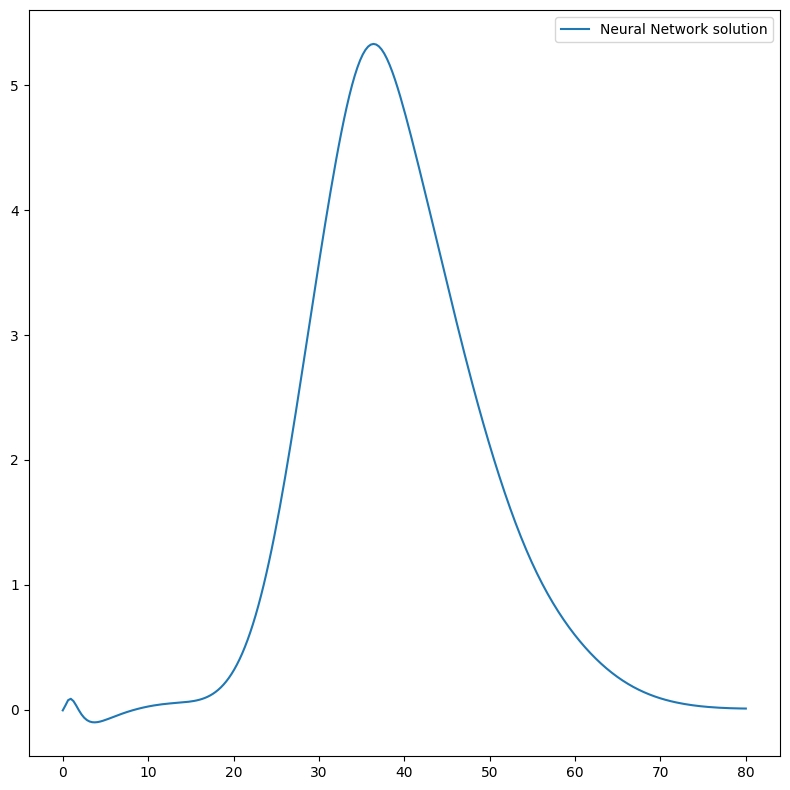

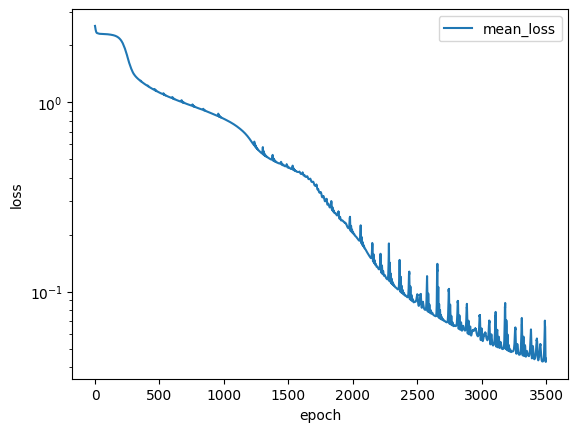

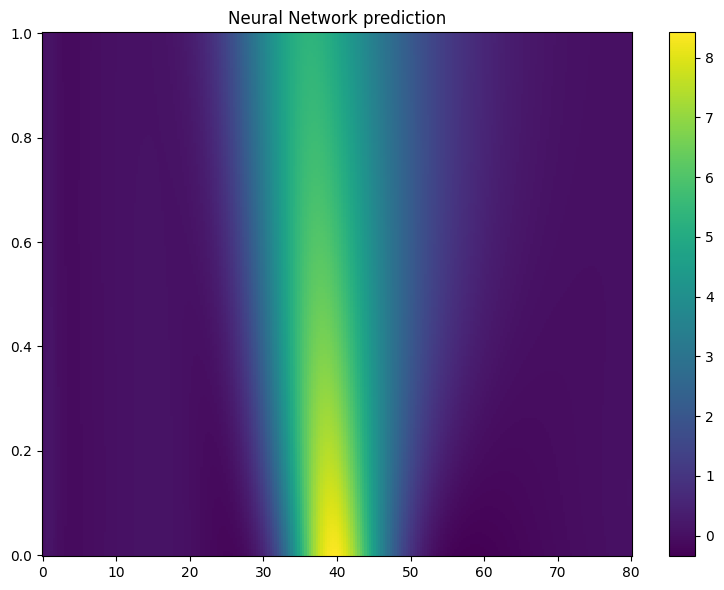

In [ ]:
class BlackScholesPDE_Butterfly(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s': [0, 80]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s = grad(output_, input_, components=['v'], d=['s'])
    v_ss = grad(v_s, input_, components=['dvds'], d=['s'])
    s = input_.extract(['s'])
    v = output_.extract(['v'])
    k_sigma = (0.02/0.2)*np.sqrt(8/(np.pi*(1/12)))
    return v_t  - ((0.2 * 0.2)*(1+ (k_sigma * torch.tensor(np.sign(v_ss.detach().numpy())))) * (s * s) / 2) * v_ss - 0.1 * s * v_s + 0.1 * v

  def initial_condition(input_, output_):
    return output_.extract(['v']) - (torch.max(input_.extract(['s'])-torch.tensor(30.), torch.tensor(0.)) - 2*torch.max(input_.extract(['s'])-torch.tensor(40.), torch.tensor(0.))+torch.max(input_.extract(['s'])-torch.tensor(50.), torch.tensor(0.)))

  def boundary_condition(input_, output_):
    return output_.extract(['v']) - 40 * torch.exp(- 0.1 * input_.extract(['t']))



  conditions = {
      'D': Condition(location=CartesianDomain({'s': [0, 80], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s': [0, 80], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s': 0, 't': [0, 1]}), equation=FixedValue(0.)),
      'BC2': Condition(location=CartesianDomain({'s': 80, 't': [0, 1]}), equation=FixedValue(0.)),
  }

problem = BlackScholesPDE_Butterfly()
problem.discretise_domain(n=5000, mode="random", variables="all", locations="all")
problem.discretise_domain(n=160, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=320, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)

trainer = Trainer(solver=pinn, max_epochs=3500, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)

trainer.train()

p3 = Plotter()
p3.plot(solver=pinn, fixed_variables={'t' : 1.0})
p3.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p3.plot(solver=pinn,method = 'pcolor')

**4.1 Cash or Nothing put option**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


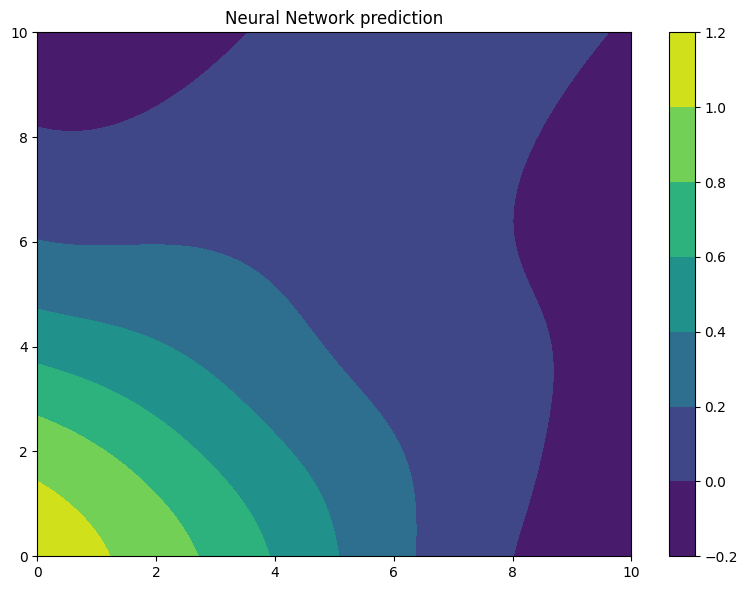

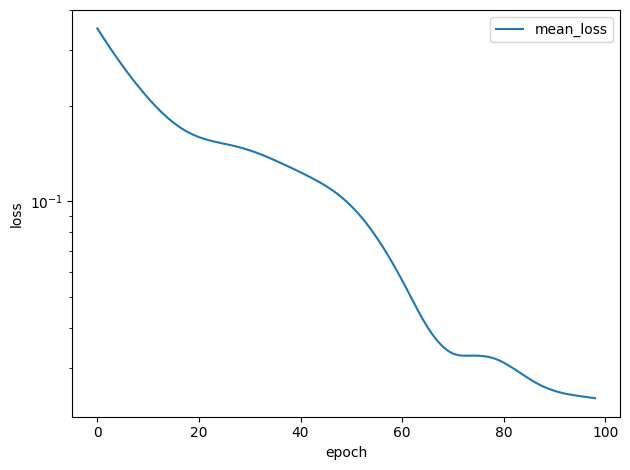

In [ ]:
class BlackScholesPDE_2D(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s1': [0, 10], 's2': [0, 10]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s1 = grad(output_, input_, components=['v'], d=['s1'])
    v_s1s1 = grad(v_s1, input_, components=['dvds1'], d=['s1'])
    v_s2 = grad(output_, input_, components=['v'], d=['s2'])
    v_s2s2 = grad(v_s2, input_, components=['dvds2'], d=['s2'])
    v_s1s2 = grad(v_s1, input_, components=['dvds1'], d=['s2'])
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    v = output_.extract(['v'])
    return v_t  - ((0.2 * 0.2) * (s1 * s1) / 2) * v_s1s1 - 0.1 * s1 * v_s1- ((0.3 * 0.3) * (s2 * s2) / 2) * v_s2s2 - 0.1 * s2 * v_s2 + 0.1 * v - 0.3*0.2*0.3*s1*s2*v_s1s2

  def initial_condition(input_, output_):
      s1 = input_.extract(['s1'])
      s2 = input_.extract(['s2'])
      return torch.where((s1 < 5) & (s2 < 5), output_.extract(['v']) - 1, output_.extract(['v']) - 0)

  def boundary_condition1(input_, output_):
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    t = input_.extract(['t'])
    v = output_.extract(['v'])
    d1 = (torch.log(s1 / 5) + (0.1 - 0.2 * 0.2 / 2) * t) / (0.2 * torch.sqrt(t))
    return v - torch.exp(-0.1 * t) * torch.tensor(norm.cdf(-d1.detach().numpy()))

  def boundary_condition2(input_, output_):
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    t = input_.extract(['t'])
    v = output_.extract(['v'])
    d2 = (torch.log(s2 / 5) + (0.1 - 0.3 * 0.3 / 2) * t) / (0.3 * torch.sqrt(t))
    return v - torch.exp(-0.1 * t) * torch.tensor(norm.cdf(-d2.detach().numpy()))




  conditions = {
      'D': Condition(location=CartesianDomain({'s1': [0, 10], 's2': [0, 10], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s1': [0, 10], 's2': [0, 10], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s1': [0, 10], 's2': 0, 't': [0, 1]}), equation=Equation(boundary_condition1)),
      'BC2': Condition(location=CartesianDomain({'s1': 0, 's2': [0, 10], 't': [0, 1]}), equation=Equation(boundary_condition2)),
  }

problem = BlackScholesPDE_2D()
problem.discretise_domain(n=20000, mode="random", variables="all", locations="all")
problem.discretise_domain(n=2000, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=1000, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)
trainer = Trainer(solver=pinn, max_epochs=100, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)
trainer.train()

p4 = Plotter()
p4.plot(solver=pinn, fixed_variables={'t' : 1.0})
p4.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p4.plot(solver=pinn,method = 'pcolor')

**Basket call option**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=7500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7500` reached.


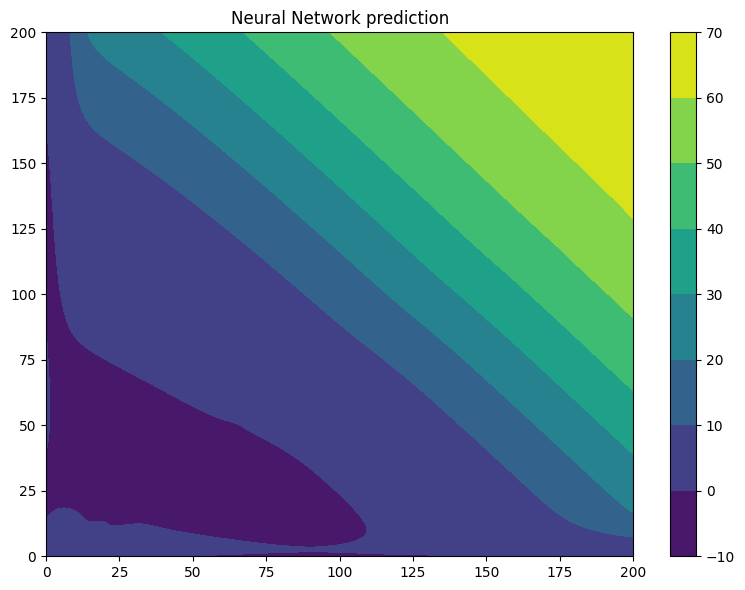

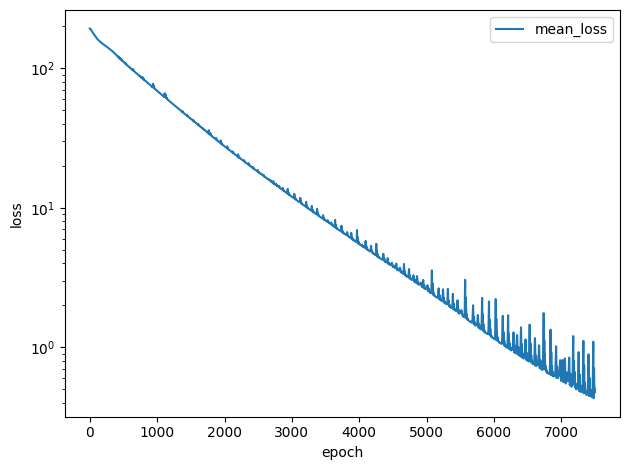

In [ ]:
class BlackScholesPDE_Basket_Option(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s1': [0, 200], 's2': [0, 200]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s1 = grad(output_, input_, components=['v'], d=['s1'])
    v_s1s1 = grad(v_s1, input_, components=['dvds1'], d=['s1'])
    v_s2 = grad(output_, input_, components=['v'], d=['s2'])
    v_s2s2 = grad(v_s2, input_, components=['dvds2'], d=['s2'])
    v_s1s2 = grad(v_s1, input_, components=['dvds1'], d=['s2'])
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    v = output_.extract(['v'])
    return v_t  - ((0.2 * 0.2) * (s1 * s1) / 2) * v_s1s1 - 0.1 * s1 * v_s1- ((0.3 * 0.3) * (s2 * s2) / 2) * v_s2s2 - 0.1 * s2 * v_s2 + 0.1 * v - 0.3*0.2*0.3*s1*s2*v_s1s2

  def initial_condition(input_, output_):
      s1 = input_.extract(['s1'])
      s2 = input_.extract(['s2'])
      return output_.extract(['v']) - torch.max(((s1+s2)/2)-torch.tensor(100.),torch.tensor(0.))

  def boundary_condition1(input_, output_):
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    t = input_.extract(['t'])
    v = output_.extract(['v'])
    d1 = (torch.log(s1 / 100) + (0.1 - 0.2 * 0.2 / 2) * t) / (0.2 * torch.sqrt(t))
    return v - (s1 - torch.tensor(100.)) * torch.exp(-0.1 * t) * torch.tensor(norm.cdf(-d1.detach().numpy()))

  def boundary_condition2(input_, output_):
    s1 = input_.extract(['s1'])
    s2 = input_.extract(['s2'])
    t = input_.extract(['t'])
    v = output_.extract(['v'])
    d2 = (torch.log(s2 / 100) + (0.1 - 0.3 * 0.3 / 2) * t) / (0.3 * torch.sqrt(t))
    return v - (s2 - torch.tensor(100.)) * torch.exp(-0.1 * t) * torch.tensor(norm.cdf(-d2.detach().numpy()))

  conditions = {
      'D': Condition(location=CartesianDomain({'s1': [0, 200], 's2': [0, 200], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s1': [0, 200], 's2': [0, 200], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s1': [0, 200], 's2': 0, 't': [0, 1]}), equation=FixedValue(0.)),
      'BC2': Condition(location=CartesianDomain({'s1': 0, 's2': [0, 200], 't': [0, 1]}), equation=FixedValue(0.)),
  }

problem = BlackScholesPDE_Basket_Option()
problem.discretise_domain(n=20000, mode="random", variables="all", locations="all")
problem.discretise_domain(n=2000, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=1000, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)
trainer = Trainer(solver=pinn, max_epochs=7500, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)
trainer.train()

p5 = Plotter()
p5.plot(solver=pinn, fixed_variables={'t' : 1.0})
p5.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p5.plot(solver=pinn,method = 'pcolor')

**Risk Adjusted Option Price**

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1500` reached.


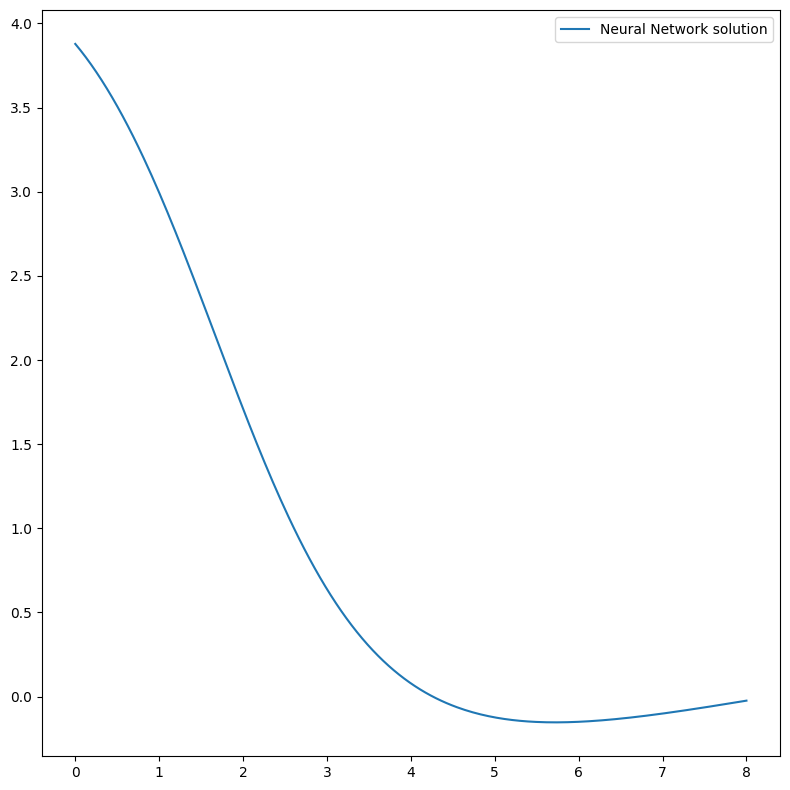

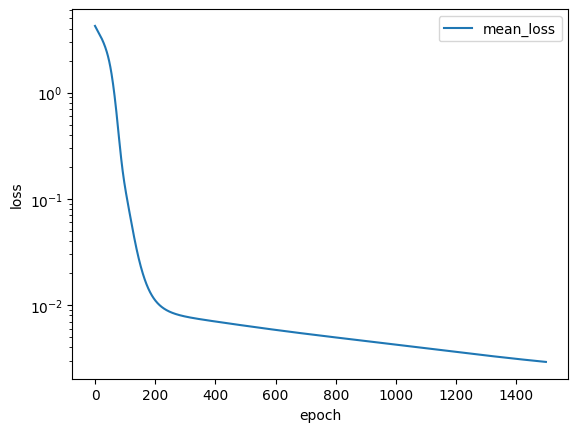

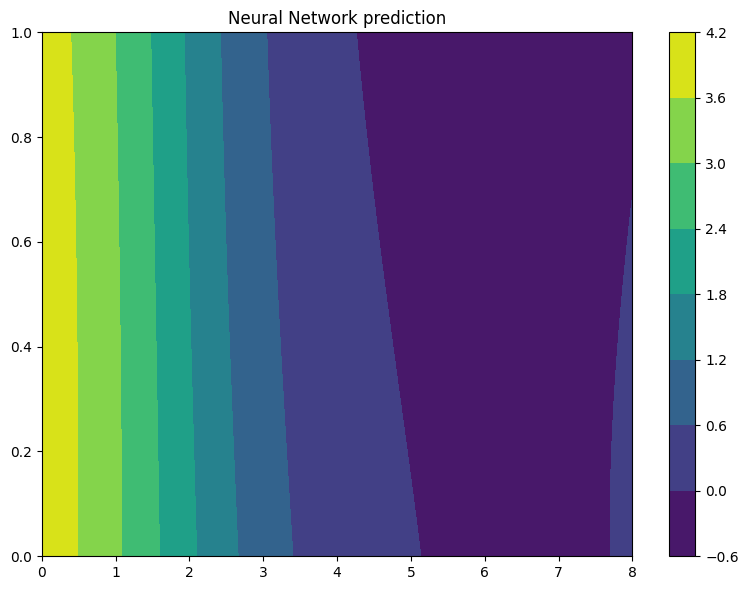

In [ ]:
class RiskAdjusted_BlackScholesPDE_1D(SpatialProblem, TimeDependentProblem):
  output_variables = ['v']
  spatial_domain = CartesianDomain({'s': [0, 8]})
  temporal_domain = CartesianDomain({'t': [0, 1]})

  def black_scholes_pde_equation(input_, output_):
    v_t = grad(output_, input_, components=['v'], d=['t'])
    v_s = grad(output_, input_, components=['v'], d=['s'])
    v_ss = grad(v_s, input_, components=['dvds'], d=['s'])
    s = input_.extract(['s'])
    v = output_.extract(['v'])
    return v_t  + ((0.3 * 0.3) * (s * s) * (1 - 0.2 * torch.pow(torch.abs(s * v_ss), 1.0 / 3.0) * torch.sign(s * v_ss)) / 2) * v_ss - 0.03 * s * v_s + 0.03 * v
    #v_t  - ((0.3 * 0.3) * (s * s) / 2) * v_ss - 0.03 * s * v_s + 0.03 * v

  def initial_condition(input_, output_):
    return output_.extract(['v']) - torch.max(torch.tensor(4.) - input_.extract(['s']), torch.tensor(0.))

  def boundary_condition(input_, output_):
    return output_.extract(['v']) - 4 * torch.exp(- 0.03 * input_.extract(['t']))



  conditions = {
      'D': Condition(location=CartesianDomain({'s': [0, 8], 't': [0, 1]}), equation=Equation(black_scholes_pde_equation)),
      'IC': Condition(location=CartesianDomain({'s': [0, 8], 't': 0}), equation=Equation(initial_condition)),
      'BC1': Condition(location=CartesianDomain({'s': 0, 't': [0, 1]}), equation=Equation(boundary_condition)),
      'BC2': Condition(location=CartesianDomain({'s': 8, 't': [0, 1]}), equation=FixedValue(0.)),
  }

problem = RiskAdjusted_BlackScholesPDE_1D()
problem.discretise_domain(n=2540, mode="random", variables="all", locations="all")
problem.discretise_domain(n=80, mode="random", variables="all", locations=["BC1", "BC2"])
problem.discretise_domain(n=160, mode="random", variables="all", locations=["IC"])

model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Tanh,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

pinn = PINN(problem, model)
trainer = Trainer(solver=pinn, max_epochs=1500, callbacks=[MetricTracker()], accelerator='cpu', enable_model_summary=False)
trainer.train()

p1 = Plotter()
p1.plot(solver=pinn, fixed_variables={'t' : 1.0})
p1.plot_loss(trainer=trainer, label = 'mean_loss', logy=True)
p1.plot(solver=pinn)